In [3]:
# Modules & set directory

import os
os.chdir("C:/Users/jaspe/PycharmProjects/phonorm")

from phonorm.utilities import create_mapping, tensor_from_pair, one_hot_encode, decode_from_ohe
from phonorm.tests import check_ohe
from phonorm.evaluate import plot_model_history, decode_sequence, evaluate_bleu, plot_bleu
from phonorm.Seq2Seq import Seq2Seq
from keras.optimizers import Adam
import numpy as np
import random

In [4]:
# Load preprocessed data
pairs = np.load("data/preprocessed/cmudict_singlechar_train.npy")

In [5]:
# Create mapping
input_lang, output_lang = create_mapping("input", "output", pairs)

# Sample training pairs (len(pairs) == entire training data set)
ml = len(pairs)
random.seed(245)
pairs_array = [random.choice(pairs) for i in range(ml)]

# Split array into input / output vectors
input_array = [pair[0] for pair in pairs_array]
output_array = [pair[1] for pair in pairs_array]

In [6]:
## One-hot encoding
encoder_in_ohe = one_hot_encode(input_array, input_lang)
decoder_in_ohe = one_hot_encode(output_array, output_lang)
decoder_out_ohe = one_hot_encode(output_array, output_lang, one_timestep_ahead=True)

In [7]:
## Check if one-hot encoding works properly by sampling 5 random pairs
check_ohe(pairs, input_lang, output_lang, 5)

decoded and 'target decoded' should be the same

---- Example 0
Input: crumb, decoded: crumb
Output: krahm, decoded: krahm, target decoded: krahm


---- Example 1
Input: caspers, decoded: caspers
Output: kaesperz, decoded: kaesperz, target decoded: kaesperz


---- Example 2
Input: prattville, decoded: prattville
Output: praetvihl, decoded: praetvihl, target decoded: praetvihl


---- Example 3
Input: creatologist, decoded: creatologist
Output: kriyeytaolahjhihst, decoded: kriyeytaolahjhihst, target decoded: kriyeytaolahjhihst


---- Example 4
Input: lorgnette, decoded: lorgnette
Output: laornyeht, decoded: laornyeht, target decoded: laornyeht




## Training the model

In [8]:
## Try
phonorm = Seq2Seq(512, input_lang, output_lang)

## Encoder
phonorm.Encoder(input_lang.n_chars, dropout_prop=0.1, recurrent_dropout_prop=0.1)

## Decoder
phonorm.Decoder(output_lang.n_chars, dropout_prop=0.1, recurrent_dropout_prop=0.1)

In [7]:
## Compile the phonorm model
phonorm.compile_model(print_summary = True, optimizer = Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 34)     0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 1024), (None 2240512     input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 28)     0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 1024)         0           bidirectional_1[0][1]            
                                                                 bidirectional_1[0][3]            
          

Train on 115342 samples, validate on 6071 samples
Epoch 1/10
115342/115342 [==============================] - 331s 3ms/step - loss: 0.1529 - val_loss: 0.0479
Epoch 2/10
115342/115342 [==============================] - 326s 3ms/step - loss: 0.0467 - val_loss: 0.0324
Epoch 3/10
115342/115342 [==============================] - 325s 3ms/step - loss: 0.0343 - val_loss: 0.0266
Epoch 4/10
115342/115342 [==============================] - 325s 3ms/step - loss: 0.0289 - val_loss: 0.0245
Epoch 5/10
115342/115342 [==============================] - 325s 3ms/step - loss: 0.0257 - val_loss: 0.0233
Epoch 6/10
115342/115342 [==============================] - 326s 3ms/step - loss: 0.0235 - val_loss: 0.0218
Epoch 7/10
115342/115342 [==============================] - 325s 3ms/step - loss: 0.0223 - val_loss: 0.0207
Epoch 8/10
115342/115342 [==============================] - 325s 3ms/step - loss: 0.0209 - val_loss: 0.0204
Epoch 9/10
115342/115342 [==============================] - 323s 3ms/step - loss: 0.01

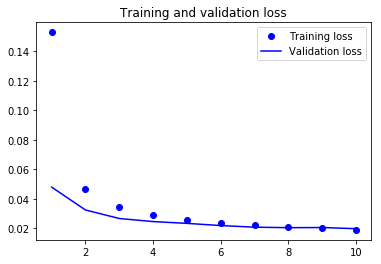

In [8]:
## Fit the model
phonorm.fit([encoder_in_ohe, decoder_in_ohe], decoder_out_ohe, batch_size = 128, epochs = 10)

In [10]:
# Predct
phonorm.predict("josje"), phonorm.predict("joasia")

('jhaoshah', 'jhowziyah')

In [9]:
# Save model
phonorm.save("models/cmudict/singlechar_model_10EP_H512")

C:\Users\jaspe\Anaconda3\envs\phonorm\lib\site-packages\keras\engine\network.py:877: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'concatenate_1/concat:0' shape=(?, 1024) dtype=float32>, <tf.Tensor 'concatenate_1_1/concat:0' shape=(?, 1024) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


In [63]:
phonorm.history

In [9]:
## Try
phonorm = Seq2Seq(512, input_lang, output_lang)
phonorm.load("models/cmudict/singlechar_model_10EP_H512")

## Evaluate the model on generic dev set

The model should perform well in terms of [BLEU score](https://machinelearningmastery.com/calculate-bleu-score-for-text-python/). This is a measure of 'skill' for the model.

In [8]:
# Load dev set
devpairs = np.load("data/preprocessed/cmudict_multichar_dev.npy")

In [9]:
# Make predictions
inWords = [pair[0] for pair in devpairs]
outWords = [pair[1] for pair in devpairs]

In [10]:
bs_out = []
preds = []
for i, (inw, outw) in enumerate(devpairs):
    
    # Predict pronunciation
    pred = phonorm.predict(inw)
    preds.append(pred)
    
    # Print if random number > 0.99
    if random.random() > 0.99:
        ## Print
        print("--- Sample " + str(i))
        print("Word: " + inw)
        print("Ref: " + outw.replace(" ", "").replace("\n", "").replace("\t", ""))
        print("Pred: " + pred)
        print("\n")
    ## Calculate bleu score
    bs_out.append(evaluate_bleu(outw.replace(" ", "").replace("\n", "").replace("\t", ""), pred))


--- Sample 1
Word: zloty
Ref: zlaotiy
Pred: zlaotiy




C:\Users\jaspe\Anaconda3\envs\phonorm\lib\site-packages\nltk\translate\bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\jaspe\Anaconda3\envs\phonorm\lib\site-packages\nltk\translate\bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


--- Sample 190
Word: expiring
Ref: ihkspayrihng
Pred: ihkspayrihng


--- Sample 213
Word: valverde
Ref: vaalvehrdey
Pred: vaalvehrdiy




In [11]:
# Bleu score
bs_1 = [bs[0].tolist()[0] for bs in bs_out]
bs_2 = [bs[1].tolist()[0] for bs in bs_out]
bs_3 = [bs[2].tolist()[0] for bs in bs_out]
bs_4 = [bs[3].tolist()[0] for bs in bs_out]

In [17]:
import matplotlib.pyplot as plt

## Plot bleu score function
def plot_bleu(data, index = 1):
    
    #%matplotlib inline
    plt.hist(data, normed=True, bins=15)
    plt.ylabel('BLEU score')
    plt.show()

1-grams avg: 0.95
2-grams avg: 0.93
3-grams avg: 0.9
4-grams avg: 0.87


C:\Users\jaspe\Anaconda3\envs\phonorm\lib\site-packages\matplotlib\axes\_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


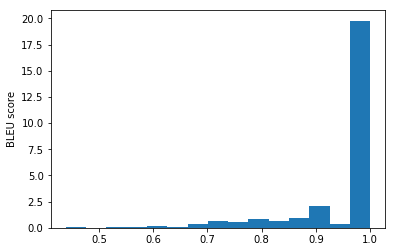

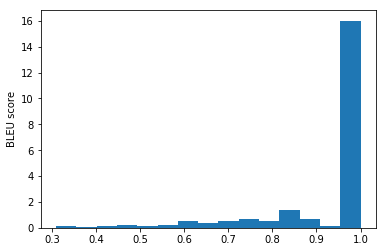

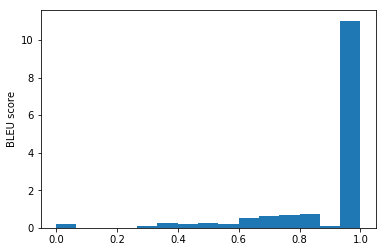

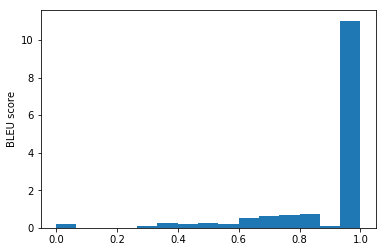

In [13]:
print("1-grams avg: " + str(np.round(np.mean(bs_1),decimals=2)))
print("2-grams avg: " + str(np.round(np.mean(bs_2),decimals=2)))
print("3-grams avg: " + str(np.round(np.mean(bs_3),decimals=2)))
print("4-grams avg: " + str(np.round(np.mean(bs_4),decimals=2)))
plot_bleu(bs_1, 1)
plot_bleu(bs_2, 2)
plot_bleu(bs_3, 3)
plot_bleu(bs_3, 4)

In [19]:
## Save data
import pandas as pd
print("In: " + str(len(inWords)))
print("Out: " + str(len(outWords)))
print("Pred: " + str(len(preds)))
print("BS1: " + str(len(bs_1)))
print("BS2: " + str(len(bs_2)))
print("BS3: " + str(len(bs_3)))
print("BS4: " + str(len(bs_4)))

# To dict
data_dev = {
    "in":inWords,
    "out":outWords,
    "pred":preds,
    "bs1":bs_1,
    "bs2":bs_2,
    "bs3":bs_3,
    "bs4":bs_4
}

# To pandas df
data_dev = pd.DataFrame.from_dict(data_dev)

# To csv
data_dev.to_csv("writeup/singlechar_dev.csv")

In: 400
Out: 400
Pred: 400
BS1: 400
BS2: 400
BS3: 400
BS4: 400


In [17]:
## Are there words that are predicted to be the same but are not in actuality
from collections import Counter
c = Counter(preds)

## Is the sum of the predicted frequencies shorter than the dev set?
## If so, then there are duplicates.
## This is an issue because we know that the dev set has homophones
sum(c.values()) == len(devpairs)

True

In [50]:
## Check out homophones set
devhmp = np.load("data/preprocessed/cmudict_multichar_homophone_dev.npy")

In [51]:
## Get unique pronunciations
unique_pronuns = []
for hmp in devhmp:
    if hmp[1] in unique_pronuns:
        continue
    else:
        unique_pronuns.append(hmp[1])
        
print("Unique pronunciations: " + str(len(unique_pronuns)))
print("Homophones dev entries: " + str(len(devhmp)))

Unique pronunciations: 247
Homophones dev entries: 614


In [52]:
equality = []
difficulty = []
inwords = []
outw = []
outw_pred = []
props_comp_to_outcome = []
props_comp_to_hmphones = []
props_all_equal = []
## For each unique pronunciation, predict
for pronun in unique_pronuns:
    
    ## Get entries where pronunciation is pronun
    pronun_entries_tmp = [entry for entry in devhmp if entry[1] == pronun]
    
    if len(pronun_entries_tmp) < 2:
        continue
    else:
        pronun_entries = pronun_entries_tmp
        
    ## Calculate equality score
    out_ref = pronun.replace(" ", "").replace("\t", "").replace("\n", "")
    
    ## Predict inwords
    out_pred = [phonorm.predict(pronun_entry[0]) for pronun_entry in pronun_entries]
    
    ## Add to list
    inwords.append("; ".join([inw[0] for inw in pronun_entries_tmp]))
    outw.append(out_ref)
    outw_pred.append("; ".join(out_pred))
    
    ## Equal to out?
    comp = [pred == out_ref for pred in out_pred]
    equality.append(comp)
    
    ## Proportion correct
    ## NB. also count instances where all entries are wrong but the same
    props_comp_to_outcome.append(np.sum(comp) / len(comp))
    
    ## Keep track of scores in a slighly different way --> look how many of the subgroups are equal to one another
    scores = []
    for grp in np.unique(out_pred):
        scores.append(np.sum([True if pr == grp else False for pr in out_pred]))
    
    props_comp_to_hmphones.append(scores[np.argmax(scores)] / sum(scores))
    
    ## All equal
    props_all_equal.append(int(np.all(comp)))
    
    ## If proportion low, then add to difficult
    if (np.sum(comp) / len(comp)) < 0.8:
        
        difficulty.append(
            {"ref":out_ref,
            "pred":out_pred,
            "inw":[entry[0] for entry in pronun_entries]}
        )

In [53]:
print("Equal to outcome: " + str(np.round(np.mean(props_comp_to_outcome), decimals=2)))
print("Highest subgroup: " + str(np.round(np.mean(props_comp_to_hmphones), decimals=2)))
print("All equal: " + str(np.round(np.sum(props_all_equal) / len(props_all_equal), decimals=2)))

Equal to outcome: 0.87
Highest subgroup: 0.91
All equal: 0.77


In [54]:
## Print
for i, difficult in enumerate(difficulty):
    
    print("----- Example " + str(i))
    print("Input: " + ", ".join(difficult["inw"]))
    print("Pred:  " + ", ".join(difficult["pred"]))
    print("True:  " + difficult["ref"])
    print("\n")

----- Example 0
Input: allegis, allegis'
Pred:  aelahjhihs, aelahjhihs
True:  aeleyjhihs


----- Example 1
Input: anno, ano
Pred:  aanow, aanow
True:  aenow


----- Example 2
Input: arman, armen, armin, armon
Pred:  aarmahn, aarmahn, aarmihn, aarmahn
True:  aarmahn


----- Example 3
Input: balentine, ballentine
Pred:  baelahntayn, baelahntayn
True:  baalehntiyniy


----- Example 4
Input: barasch, barash
Pred:  baarahsh, baarahsh
True:  baerahsh


----- Example 5
Input: bohnet, bonnett
Pred:  bowniht, baaniht
True:  baaniht


----- Example 6
Input: buchanan's, buchanans
Pred:  byuwkaenahnz, byuwkeynahnz
True:  byuwkaenahnz


----- Example 7
Input: charlene, charline, sharleen, sharlene
Pred:  chaarliyn, chaarlayn, shaarliyn, shaarliyn
True:  shaarliyn


----- Example 8
Input: comet's, comets
Pred:  kaamahts, kaamihts
True:  kaamahts


----- Example 9
Input: coppee, copy, kopy
Pred:  kaapiy, kowpiy, kowpiy
True:  kaapiy


----- Example 10
Input: critzer, kritzer
Pred:  kraytzer, krihtzer

In [56]:
# To pandas dataframe
import pandas as pd

data_dev_hmp = {
    "in":inwords,
    "pred": outw_pred,
    "out":outw,
    "equality":equality,
    "props_comp_to_outcome":props_comp_to_outcome,
    "props_comp_to_hmphones":props_comp_to_hmphones,
    "props_all_equal":props_all_equal
}

# To pandas df
data_dev = pd.DataFrame.from_dict(data_dev_hmp)

# To csv
data_dev.to_csv("writeup/singlechar_dev_hmp.csv")

### Misspelled words

In [30]:
## Load data
misp = np.load('data/preprocessed/wikipedia_misspelled.npy')

In [45]:
badpreds = []
goodpreds = []
tp = 0
fp = 0
tn = 0
fn = 0
wrong = []
for (pair, score) in misp:
    
    # Predict pronunciation
    try:
        bpred = phonorm.predict(pair[0])
        gpred = phonorm.predict(pair[1])
    except:
        continue
    
    badpreds.append(bpred)
    goodpreds.append(gpred)
    
    # If bpred and gpred are the same and score == 1 (pronunciation of the words is the same), then add to accuracy
    if bpred == gpred:
        are_equal = True
    else:
        are_equal = False
    
    if score == 0:
        if are_equal == False:
            tn += 1
        else:
            fn += 1
            wrong.append([pair, bool(score), [bpred, gpred], True])
    else:
        if are_equal:
            tp += 1
        else:
            fp += 1
            wrong.append([pair, bool(score), [bpred, gpred], False])
    
    # Print if random number > 0.99
    if random.random() > 0.5:
        ## Print
        print("----------")
        print("Misspelled: " + pair[0] + ", Pred: " + bpred)
        print("Correct: " + pair[1] + ", Pred: " + gpred)
        print("\n")

----------
Misspelled: casued, Pred: kaesuwd
Correct: caused, Pred: kaozd


----------
Misspelled: carryng, Pred: kaerihng
Correct: carrying, Pred: kaeriyihng


----------
Misspelled: attendence, Pred: ahtehndahns
Correct: attendance, Pred: ahtehndahns


----------
Misspelled: helment, Pred: hhehlmahnt
Correct: helmet, Pred: hhehlmiht


----------
Misspelled: seperatism, Pred: sehperahtihzahm
Correct: separatism, Pred: sehperahtihzahm


----------
Misspelled: condidtions, Pred: kahndihshahnz
Correct: conditions, Pred: kahndihshahnz


----------
Misspelled: celcius, Pred: sehlsiyihs
Correct: celsius, Pred: sehlsiyihs


----------
Misspelled: ceromony, Pred: sehrahmowniy
Correct: ceremony, Pred: sehrahmowniy


----------
Misspelled: negotation, Pred: nehgahteyshahn
Correct: negotiation, Pred: nihgowshiyeyshahn


----------
Misspelled: candiate, Pred: kaendiyaht
Correct: candidate, Pred: kaendahdeyt


----------
Misspelled: agricuture, Pred: ahgrihkyahcher
Correct: agriculture, Pred: aegr

In [49]:
# Metrics
acc = (tp + tn) / (tp + fp + tn + fn)
sens = tp / (tp + fn)
spec = tn / (fn + tn)
f1 = 2*(sens * spec) / (sens + spec)
#-----

print("Accuracy: " + str(acc))
print("Sensitivity: " + str(sens))
print("Specificity: " + str(spec))
print("F1: " + str(f1))

Accuracy: 0.94
Sensitivity: 0.868421052631579
Specificity: 0.9242424242424242
F1: 0.8954626334519573


In [44]:
wrong

[[['differentiatiations', 'differentiations'],
  False,
  ['dihferehnshiyeyshahnz', 'dihferehnshiyeyshahnz'],
  True],
 [['rebiulding', 'rebuilding'], False, ['riybihldihng', 'riybihldihng'], True],
 [['opression', 'oppression'], False, ['ahprehshahn', 'ahprehshahn'], True],
 [['ghandi', 'gandhi'], True, ['gaandiy', 'gaendiy'], False],
 [['statememts', 'statements'], False, ['steytmahnts', 'steytmahnts'], True],
 [['excange', 'exchange'], False, ['ihkscheynjh', 'ihkscheynjh'], True]]